# Machine Learning and Anomaly Detection

-----

This notebook extends anomaly detection beyond basic statistical techniques to include the construction and application of machine learning models. A machine learning model can by default identify inliers, or data that support the model, and also outliers, or data that do not support the model. In addition, many modeling techniques can assign probabilities to 
these identifications, which make them more powerful since we often do not know a priori exactly what constitutes an anomaly (e.g., fraud). Thus, we can compute the probabilistic likelihoods from a model, and perform sampling of the results to determine a probability threshold that can be applied ore generally.

The rest of this notebook employs several techniques to demonstrate how anomalies can be identified by using machine learning. First, we use classification to model the distribution defined by the majority of the data. Second, we use cluster analysis to fid clusters in a data set, as well as those points that lie outside the high density regions. Finally, we employ dimension reduction to identify instances that are different than the majority of the data. 

-----

## Table of Contents

[Anomaly Detection: Iris Data](#Anomaly-Detection:-Iris-Data)

- [Anomaly Detection: Cluster Analysis](#Anomaly-Detection:-Cluster-Analysis)

- [Anomaly Detection: Classification Analysis](#Anomaly-Detection:-Classification-Analysis)

[Anomaly Detection: Digit Data](#Anomaly-Detection:-Digit-Data)

- [Anomaly Detection: Dimension Reduction](#Anomaly-Detection:-Dimension-Reduction)

-----

Before proceeding with the rest of this notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default Seaborn plotting style
sns.set_style('white')

----

[[Back to TOC]](#Table-of-Contents)

## Anomaly Detection: Iris Data

To demonstrate several machine learning techniques that can be used for identifying anomalies, we will use the Iris data. The first Code cell below loads these data into a DataFrame and relabels the columns to be easier to read, especially when plotting. However, these data, as we have repeatedly seen are easy to classify or cluster. 

Thus, to complicate matters, we add artificial data to this DataFrame by using the same strategy employed in the statistical based anomaly detection notebook. This includes high noise instances, instances with features transposed, and instances with incorrect units. The second Code cell below adds these types of anomalies to the _Sepal Width_ feature, while the third Code cell below adds these types of anomalies to the _Sepal Length_ feature.

----

In [2]:
# Grab the iris data, modify column names for pretty plotting
iris = sns.load_dataset('iris')
iris.columns = ['Sepal Length', 'Sepal Width', 
                'Petal Length', 'Petal Width', 'Species']

In [3]:
from scipy.stats import uniform

# Generate Sepal Width outlier data
data = iris['Sepal Width']
mu = np.mean(data)
sig = np.std(data)

# First, we add extreme outliers in Sepal Width
x = np.append(data, (mu - 2.0 * sig) * uniform.rvs(0.9, 1.1, size=10))
x = np.append(x, (mu + 2.0 * sig) * uniform.rvs(0.9, 1.1, size=10))

# Second, we add Petal Width features to the Sepal Width feature
x = np.append(x, iris['Petal Width'][-20:], axis=0)

# Finally, we convert units on some instances (cm to in) 
x = np.append(x, iris['Sepal Width'][-20:]/2.54, axis=0)

In [4]:
# Generate Sepal Length outlier data
data = iris['Sepal Length']
mu = np.mean(data)
sig = np.std(data)

# Add extreme outliers
y = np.append(data, (mu - 2.0 * sig) * uniform.rvs(0.9, 1.1, size=10))
y = np.append(y, (mu + 2.0 * sig) * uniform.rvs(0.9, 1.1, size=10))

# Add transposed feature outliers
y = np.append(y, iris['Petal Length'][-20:], axis=0)

# Add incorrect unit outliers
y = np.append(y, iris['Sepal Length'][-20:]/2.54, axis=0)

-----
[[Back to TOC]](#Table-of-Contents)

### Anomaly Detection: Cluster Analysis

At its core, anomaly detection is generally defined as identifying those data instances that are different from the majority of the data under analysis. For example, when looking for fraud in a financial statement, we seek to identify the (hopefully) rare events that are different than the majority of transactions. In this case, one can view the problem as finding the clusters of normal data, and using these clusters to identify data that are outside, that is _outliers_, of the normal groupings inherent within the data. 

In this approach, we often will start with a clustering technique that does not require an initial estimate for the number of clusters (although if we know _how our data are normally distributed_, we can use this _a priori_ information to guide the process). As a result, clustering techniques like DBSCAN, which we covered in a previous notebook, are useful since they both identify clusters and points (called _noise_) that are outside the clusters. 

In the following two Code cells, we first apply the DBSCAN algorithm on our modified Iris data set to find clusters and noise points. We use a `Counter` in the standard Python library to simplify the counting of the unique cluster members. In addition, we use basic hyperparameters for the DBSCAN algorithm, which could be tuned to improve performance. In the second Code cell, we visualize the results for comparison. 

Recall that when using DBSCAN, points labeled as `class=-1` are considered noise points. Notice how the cluster algorithm recovers three clusters that match the basic high density regions of the Iris data set. In addition, those points clearly separated from the main distribution of points are marked as noise, which in theory is how we expect anomalies to be identified. In practice, however, this technique likely needs to be augmented with a statistical technique to provide probabilistic classification of outliers.

-----


In [5]:
# We will use DBSCAN from scikit-learn
from sklearn.cluster import DBSCAN

data = np.array((x, y)).T
dbs = DBSCAN(eps=0.25, min_samples=10)
dbs.fit(data)

from collections import Counter
cnt =  Counter(np.sort(dbs.labels_))

# Display some basic results of the clustering
print('DBSCAN Cluster membership.')
print(30*'-')
for itm in cnt:
    if itm < 0:
        print(f'Noise Cluster : {cnt[itm]:>4d} members')
    else:
        print(f'Cluster {itm}     : {cnt[itm]:>4d} members')

DBSCAN Cluster membership.
------------------------------
Noise Cluster :   74 members
Cluster 0     :   35 members
Cluster 1     :   83 members
Cluster 2     :   18 members


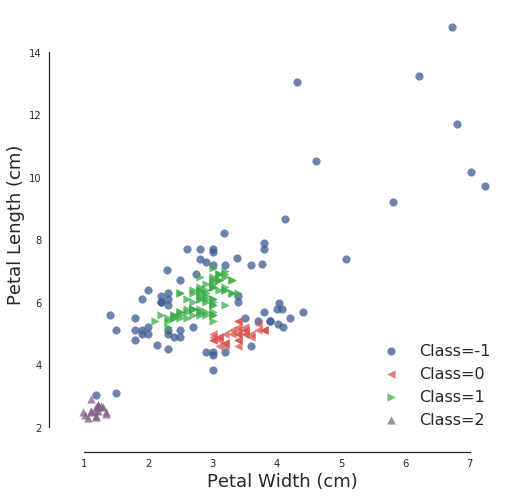

In [6]:
# Plot clustered data
def make_plot(df, axs, lbl, c, m):
    
    # Extract Sepal Width for given label
    xx = df[df.Label==lbl][['SW']]
    
    # Extract Sepal Length for given label
    yy = df[df.Label==lbl][['SL']]
    
    # Plot sepal width versus sepal length
    axs.scatter(xx, yy, color=c, marker=m, alpha =0.75, s=60, 
                label='Class={0}'.format(lbl))

# Create Data Frame from clustered data, rename columns for simplicity
df = pd.DataFrame({'SW': x, 'SL': y, 'Label': dbs.labels_})

# Create figure
fig, axs = plt.subplots(figsize=(8, 8))

# Define color and markers for plots (assume only four clusters)
ca = [sns.xkcd_rgb['denim blue'], sns.xkcd_rgb['pale red'], 
      sns.xkcd_rgb['medium green'], sns.xkcd_rgb['dusty purple']]
ma = ['o', '<', '>', '^']

# Iterate through clusters
for idx, lbl in enumerate(np.unique(dbs.labels_)):
    make_plot(df, axs, lbl, ca[idx], ma[idx])

# Decorate plot
axs.legend(loc=4)
axs.set_xlabel('Petal Width (cm)')
axs.set_ylabel('Petal Length (cm)')
sns.despine(offset=10, trim=True)

-----
[[Back to TOC]](#Table-of-Contents)

### Anomaly Detection: Classification Analysis

One seemingly obvious technique for identifying anomalies is to employ classification to identify data that are somehow different. While this may sound simple, in practice it can be difficult. For example, how do you define _different_, and from what, exactly, are new points different? The general solution to this challenge is to construct a classification model from _good_ data and use this model to identify anomalies. But without knowing the _good_ data, this process is made considerably more complicated.

A simple approach to solving this problem is to use _some_ of the data to build an initial model. Next, one uses this initial model to identify the likelihood that _new_ data  are inliers or outliers. As necessary, this model can be iteratively improved by analyzing the probabilistic classification of new points and constructing suites of models from different subsamples of the initial data. Alternatively, one can perform a one versus rest classification to quantify the likelihood that each point is affiliated with the others, via the construction of a _support_ measurement. 

A simple technique that combines these two approaches is provided by the [One Class SVM][skocsvm] estimator in the `svm` module in the scikit learn library. This classification method takes input data with no labels and builds a model of the data. This model can be used to quantify the support, and to identity the likelihood that new points are in the model (inliers) or out of the model (outliers). 

We demonstrate this algorithm in the following Code cell by using the modified _Iris_ data we constructed previously in this notebook. We first construct a sample of points in a two-dimensional space (defined by the _Sepal Width_ and _Sepal Length_ features) by using a `meshgrid`. Next, we create the classifier, train it using the modified data, and apply it to the mesh grid and data points to determine the likelihood that points are inliers or outliers. The resulting figure demonstrates that many outliers are removed, and in a quantifiable manner, given the contours.

-----

[skocsvm]: http://scikit-learn.org/stable/modules/svm.html#svm-outlier-detection

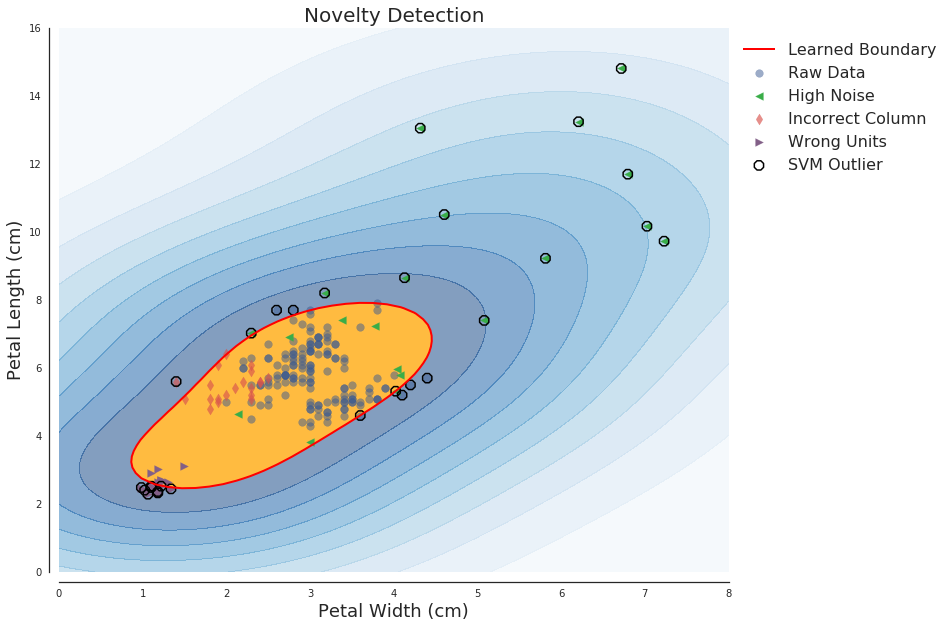

In [7]:
# Modified from scikit learn example:
# http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import scale

# Make a meshgrid from the input space
xx, yy = np.meshgrid(np.linspace(0, 8, 50), np.linspace(0, 16, 100))

# scikit learn recommended formula
of = 0.1 # Expected Outlier Fraction
nuv = 0.95 * of + 0.05

# Create scikit learn SVC estimator, fit to data, and predict labels
svc = OneClassSVM(nu=nuv, kernel="rbf", gamma=0.1)
svc.fit(data)
preds = svc.predict(data)

# Apply the SVC decision function to meshgrid
z = svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

# Create figure
fig, axs = plt.subplots(figsize=(12, 10))

# Draw contours for SVC decision surface
axs.contourf(xx, yy, z, levels=np.linspace(z.min(), 0, 10), 
             cmap=plt.cm.Blues, alpha=0.5)

# Colorize central region where data are marked good
axs.contourf(xx, yy, z, levels=[0, z.max()], 
             colors='orange', alpha=0.75)

# Draw contour line for boundary and set label
cnt = axs.contour(xx, yy, z, levels=[0], linewidths=2, colors='red')
cnt.collections[0].set_label('Learned Boundary')
    
# Plot Iris data
p1 = axs.scatter(x[:-60], y[:-60], 
                 color=sns.xkcd_rgb['denim blue'], s=60, alpha=0.5,
                 label='Raw Data')

# Transpose high noise data
p2 = axs.scatter(x[-60:-40], y[-60:-40], 
                 color=sns.xkcd_rgb['medium green'], s=60, marker='<',
                 label='High Noise')

# Plot transposed feature data
p3 = axs.scatter(x[-40:-20], y[-40:-20], 
                 color=sns.xkcd_rgb['pale red'], s=60, marker='d', alpha=0.65,
                 label='Incorrect Column')

# Plot wrong unit data
p4 = axs.scatter(x[-20:], y[-20:], 
                 color=sns.xkcd_rgb['dusty purple'], s=60, marker='>',
                 label='Wrong Units')

# Now mark the outliers, they have prediction class = -1. 
# To simplify finding them we use a temporary DataFrame
df = pd.DataFrame({'x': x, 'y': y, 'p': preds})
p5 = axs.scatter(df[df.p < 0].x, df[df.p < 0].y, s=100,
                 marker='8', facecolor='none', edgecolor='black',
                 linewidth=1.5, linestyle='-',
                label='SVM Outlier')

# Decorate plot
axs.set(title='Novelty Detection', 
        xlabel='Petal Width (cm)', ylabel='Petal Length (cm)')
axs.legend(bbox_to_anchor=(1.0, 1), loc=2)
sns.despine(offset=10, trim=True)

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used several outlier detection techniques to identify manually added outliers to the Iris data. Now that you have run the Notebook, go back and make the following changes to see how the results change.

1. Change the number of outlier points added to the two _Sepal_ features, including noise points, transposed columns, and incorrect measurements. How does this visually change the distribution? How does it affect the statistical summarizations?
2. Change the parameters used in the DBSCAN algorithm. How does this affect the outlier detection? How does bandwidth used in the KDE estimator. How does this affect the resulting plot?
3. Try using a different kernel function, for example a `linear` or `poly` with the `OneClassSVM`. How does this affect the outlier detection process?

Finally, the previous cells only modified the _Sepal_ features, try making four-dimensional fake data by creating fake _Petal_ features as well. Can you still apply the demonstrated techniques to the four dimensional data set.

-----

[[Back to TOC]](#Table-of-Contents)

## Anomaly Detection: Digit Data

While insightful, the Iris data, even when augmented with artificial data, is still a low-dimensional data set. Thus, we now switch to a second data set. For the rest of this notebook, we will explore anomaly detection by using the handwritten digit data set. First we will load the data, augment these data with fake images, and review both the real and fake data.

Note that the creation of the fake images is performed in a separate file that we import. The fake data consist of images that are clearly not digits, including vertical and horizontal bars, tee-shaped images, and also u-shaped images. We also generate images for the digits one and seven that are shifted horizontally. Thus, some of the images are visually similar to the real digit data, while others should be more easy to distinguish.

-----

Total number of samples = 1797


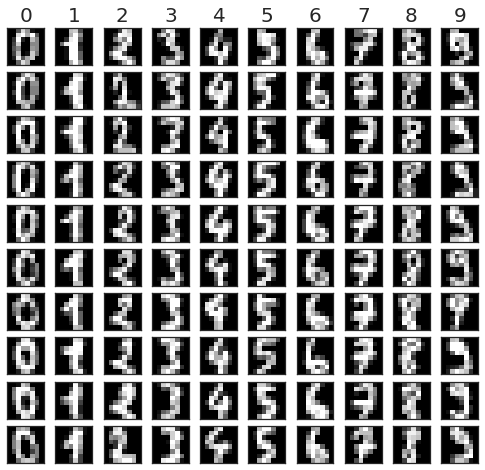

In [8]:
# We have helper code to assist in the loading and plotting of these data
from helper_code import digits as hd

# We extract features (x), labels (y), and the images for plotting.
x, y, images = hd.get_data()
hd.im_plot(x, y, images)

print('Total number of samples = {0}'.format(y.shape[0]))

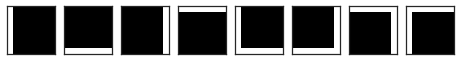

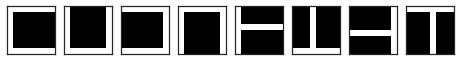

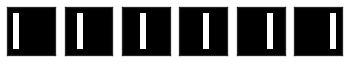

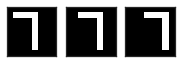

In [9]:
# Generate fake data
from helper_code import digits as hd

# Make clearly non-real image dara
fakes = hd.make_fakes()

# Plot fake data in two rows
hd.plot_numbers(fakes[:8])
hd.plot_numbers(fakes[8:])

# Make and plot ones
ones = hd.make_ones()
hd.plot_numbers(ones)

# Make and plot sevens
sevens = hd.make_sevens()
hd.plot_numbers(sevens)

-----
[[Back to TOC]](#Table-of-Contents)

### Anomaly Detection: Dimension Reduction

With the digit data loaded, and the fake digit data created, we first need to combine these data into a new array. We have twenty-five _fake_ images, to go along with the _real_ digit data. In the following Code cell, we create a new array that contains first the original digit data, followed by the fake digits, and finally the ones and sevens that we created.  To do this, we first create a copy of the original array and append the fake data to the new array.

Next, we perform principal component analysis on the new data to transform the original sixty-four dimension feature space to a lower dimension space (in this case we by default use an eight-dimensional space). Once this transformation is complete, we compute and display the explained variance from each PCA component. 

The third Code cell plots the distribution of combined digit data in two plots. The first uses the primary PCA components, while the second uses the last two PCA components. These plots demonstrate how a small number of _noisy_ data, or outliers, can often be identified, and thus removed, from a data set by transforming into a lower dimensional space.

-----

In [10]:
# Copy original data, rescale data so that it is zero or sixteen.
x2 = x.copy()
x2[x2 > 0] = 16

# Add fake data, and ones and sevens
xx = np.append(x2, fakes, axis=0)
xx = np.append(xx, ones, axis=0)
xx = np.append(xx, sevens, axis=0)

In [11]:
# Principal Component Analysis
from sklearn.decomposition import PCA

# Number of fake images
n_fakes = 25

# Compute PCA for digit data and transform
pca = PCA(n_components=8, copy=True)
from sklearn.preprocessing import scale

# Normalize data and apply PCA transformation
data = pca.fit_transform(scale(xx))

print("Explained Variance per PCA component\n", 35*'-')
for idx, val in enumerate(pca.explained_variance_ratio_):
    print('PCA component {0:2d}: {1:4.1f}%'.format(idx, val*100))
    
print(35*'-', '\nTotal Explained Variance (All PCA components: {0:4.1f}%\n'.format(
 sum(pca.explained_variance_ratio_[:]*100)))

print('Variance explained (First two PCA components): {0:4.1f}%\n'.format(
    sum(pca.explained_variance_ratio_[:2]*100)))

print('Variance explained (Last two PCA components): {0:4.1f}%\n'.format(
    sum(pca.explained_variance_ratio_[-2:]*100)))

Explained Variance per PCA component
 -----------------------------------
PCA component  0: 12.7%
PCA component  1:  8.4%
PCA component  2:  7.7%
PCA component  3:  6.7%
PCA component  4:  5.4%
PCA component  5:  4.3%
PCA component  6:  3.8%
PCA component  7:  3.5%
----------------------------------- 
Total Explained Variance (All PCA components: 52.6%

Variance explained (First two PCA components): 21.2%

Variance explained (Last two PCA components):  7.3%



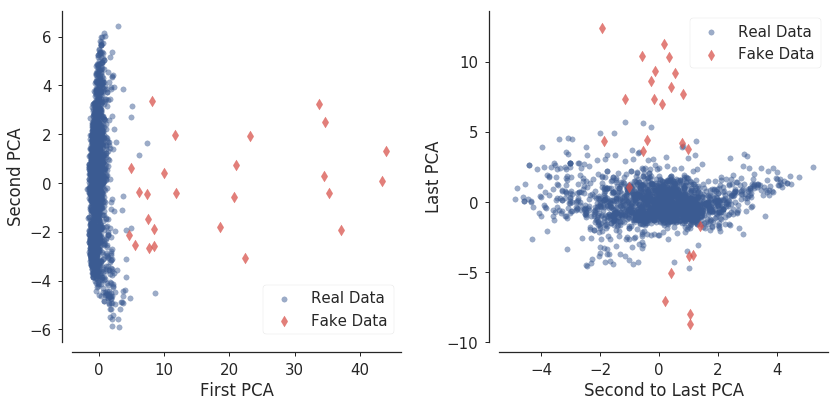

In [12]:
# Define plot style
sns.set(style='white', font_scale=1.5, 
        rc={'xtick.major.size': 4.0, 'ytick.major.size': 4.0})

# Function to plot data in PCA components
def plot_digit_pca(x, y, idx, ax, llc, xlbl, ylbl):
    
    # Plot real data in specified dimensions
    ax.scatter(x[:-idx], y[:-idx], 
               color=sns.xkcd_rgb['denim blue'], marker='o', alpha=0.5, s=30, 
               label='Real Data')
    
    # Plot fake data in specified dimensions
    ax.scatter(x[-idx:], y[-idx:], 
               color=sns.xkcd_rgb['pale red'], marker='d', alpha=0.75, s=60, 
               label='Fake Data')

    # Decorate plot
    ax.legend(loc=llc, frameon=True)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    sns.despine(offset=10)

# Create figure
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot data in first two PCA components
plot_digit_pca(data[:, 0], data[:, 1], n_fakes, axs[0], 4, 
               'First PCA', 'Second PCA')

# Plot data in last two PCA components
plot_digit_pca(data[:, -2], data[:, -1], n_fakes, axs[1], 1, 
               'Second to Last PCA', 'Last PCA')

# Cleanup plot
plt.tight_layout()

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used PCA to transform the combined digit data and to explore the distribution of the real data and outliers in two-dimensional plots by using different PCA components. Now that you have run the Notebook, go back and make the following changes to see how the results change.

1. Change the number of PCA components lower and higher. How does this affect the separation of the outliers?
2. Change the PCA components used to make these plots, for example to the third and fourth component. How does this affect the separation of the outliers?
3. Try making a new fake data point that combines the 'bar' image from the helper code with an existing number, such as a six. Using a different color ini the plots for this data point, where does this new, more realistic _fake_ data point lie in the previous plots?

Finally, try applying a classifier on the new digit data. Can you explain (feel free to use the class forums) why the classification algorithm performed in the  manner it did for the new _fake_ digits?

-----

## Ancillary information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. Scikit learn library documentation for [novelty and outlier detection][1]
1. Article on [outlier detection][2] from the machine learning mastery website
2. Blog article on [outlier detection][3] with Python


-----

[1]: http://scikit-learn.org/stable/modules/outlier_detection.html
[2]: https://machinelearningmastery.com/how-to-identify-outliers-in-your-data/
[3]: http://napitupulu-jon.appspot.com/posts/outliers-ud120.html

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 